### 데이터 로드 및 초기 설정

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# 데이터 경로 설정
raw_data_path = "../../data/raw"  # notebooks/EDA에서 상위 폴더를 기준으로 설정
train_image_path = os.path.join(raw_data_path, "train")
test_image_path = os.path.join(raw_data_path, "test")

# CSV 파일 로드
meta_df = pd.read_csv(os.path.join(raw_data_path, "meta.csv"))
train_df = pd.read_csv(os.path.join(raw_data_path, "train.csv"))
sample_submission_df = pd.read_csv(os.path.join(raw_data_path, "sample_submission.csv"))


## 데이터 이해 및 통계적 탐색

### 데이터 크기 및 통계 확인

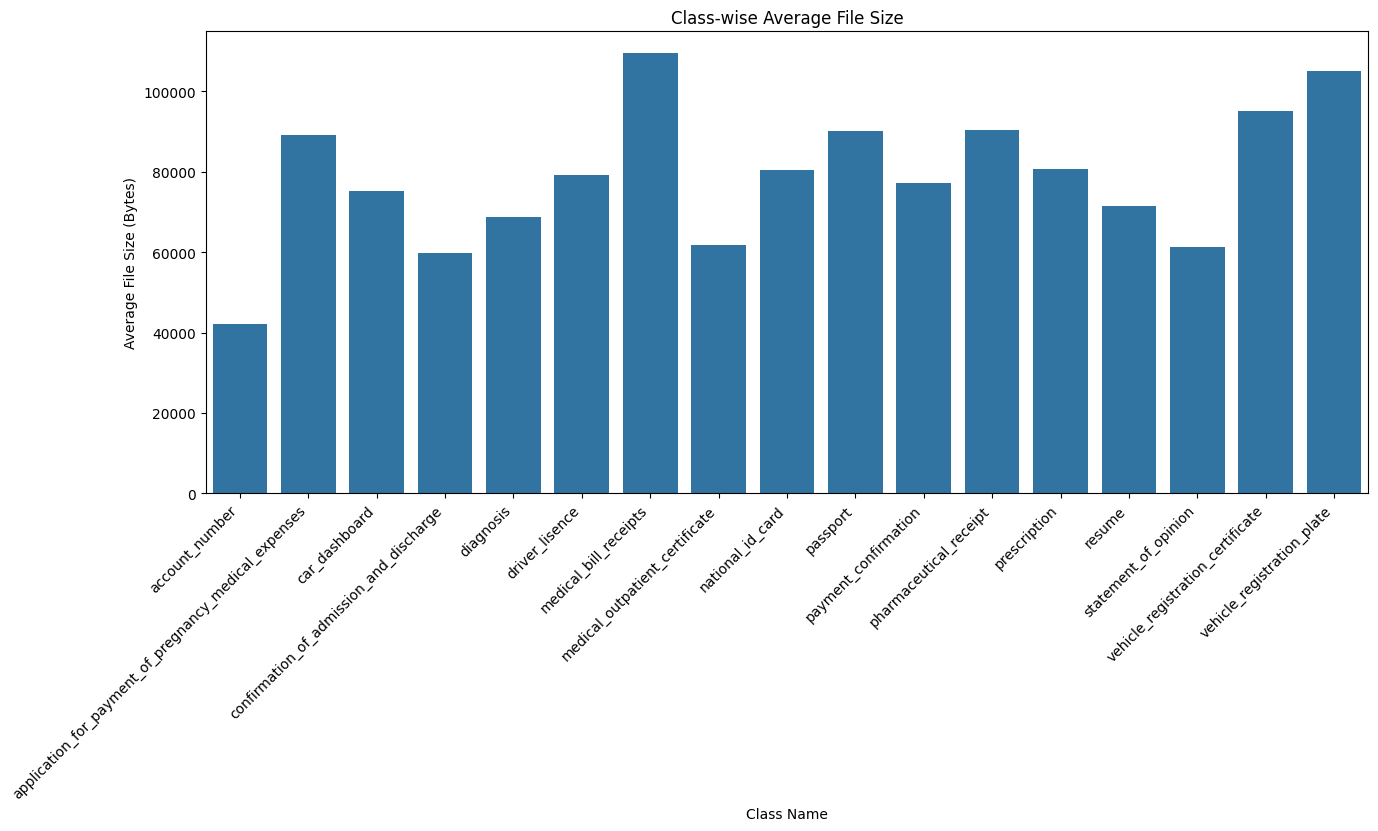

,class_name,avg_width,avg_height,std_width,std_height,avg_file_size,std_file_size
0,account_number,482.96,551.030000,66.037014,66.030978,42133.800000,13593.477881
1,application_for_payment_of_pregnancy_medical_e...,443.00,591.000000,0.000000,0.000000,89213.326087,9398.057461
2,car_dashboard,588.04,445.960000,20.824384,20.824384,75113.530000,11269.990491
3,confirmation_of_admission_and_discharge,443.00,591.000000,0.000000,0.000000,59786.710000,7780.649990
4,diagnosis,443.00,591.000000,0.000000,0.000000,68716.050000,9024.520102
5,driver_lisence,611.81,431.690000,53.886468,46.465953,79211.440000,13713.363634
6,medical_bill_receipts,499.21,535.380000,74.818743,75.350867,109469.210000,10268.083273
7,medical_outpatient_certificate,443.00,591.000000,0.000000,0.000000,61693.540000,8123.638391
8,national_id_card,613.43,430.960000,55.327903,49.309765,80438.190000,19417.847993
9,passport,608.98,432.560000,46.724419,38.411730,90176.180000,13011.436815


In [3]:
# 해상도 및 파일 크기 계산 함수
def calculate_image_stats(image_folder, train_with_meta):
    stats = []
    for _, row in train_with_meta.iterrows():
        img_file = row['ID']
        class_name = row['class_name']  # class_name으로 변경
        img_path = os.path.join(image_folder, img_file)
        img = Image.open(img_path)
        file_size = os.path.getsize(img_path)
        width, height = img.size
        stats.append([class_name, width, height, file_size])
    stats_df = pd.DataFrame(stats, columns=['class_name', 'width', 'height', 'file_size'])
    return stats_df

# meta.csv와 train.csv 병합 (class_name 사용)
train_with_meta = train_df.merge(meta_df, on="target")

# 이미지 통계 계산
train_image_stats = calculate_image_stats(train_image_path, train_with_meta)

# 클래스별 평균 및 표준편차 계산
summary_stats = train_image_stats.groupby('class_name').agg(
    avg_width=('width', 'mean'),
    avg_height=('height', 'mean'),
    std_width=('width', 'std'),
    std_height=('height', 'std'),
    avg_file_size=('file_size', 'mean'),
    std_file_size=('file_size', 'std')
).reset_index()

# 결과 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.barplot(data=summary_stats, x='class_name', y='avg_file_size')
plt.title('Class-wise Average File Size')
plt.xlabel('Class Name')
plt.ylabel('Average File Size (Bytes)')
plt.xticks(rotation=45, ha='right')  # 클래스 이름 보기 좋게 회전
plt.show()

# 통계 출력
summary_stats


/tmp/ipykernel_79391/3698521202.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = train_image_stats.groupby(['class_name', 'file_size_bin']).size().unstack(fill_value=0)
/tmp/ipykernel_79391/3698521202.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('jet', len(bin_stats.columns))


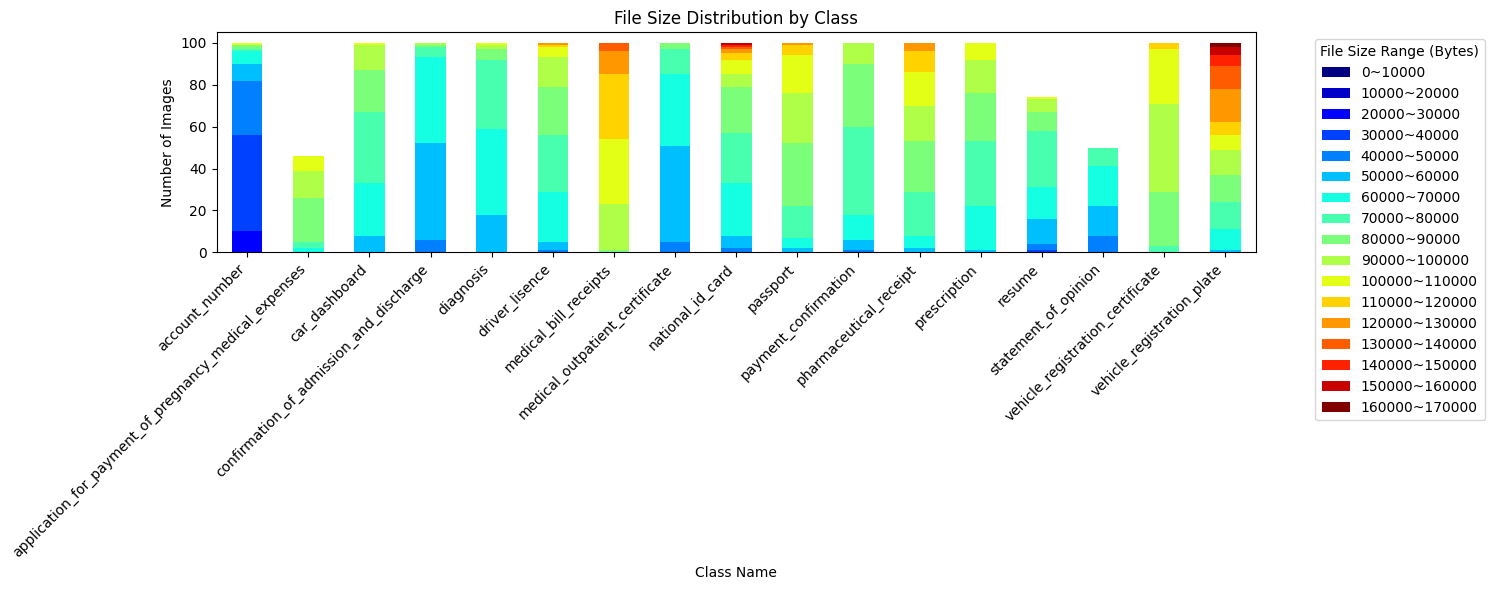

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# 파일 크기 구간(bin) 설정
bins = np.arange(0, train_image_stats['file_size'].max() + 10000, 10000)  # 10000 단위 구간
bin_labels = [f"{int(bins[i])}~{int(bins[i + 1])}" for i in range(len(bins) - 1)]

# 파일 크기를 구간으로 변환
train_image_stats['file_size_bin'] = pd.cut(train_image_stats['file_size'], bins=bins, labels=bin_labels)

# 클래스별 구간별 데이터 개수 계산
bin_stats = train_image_stats.groupby(['class_name', 'file_size_bin']).size().unstack(fill_value=0)

# jet 색상 맵 생성
cmap = get_cmap('jet', len(bin_stats.columns))
colors = [cmap(i) for i in range(len(bin_stats.columns))]

# 누적 막대 그래프 그리기
ax = bin_stats.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 6),
    color=colors  # jet 색상 적용
)

# 그래프 꾸미기
plt.title("File Size Distribution by Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')  # 클래스 이름 보기 좋게 회전
plt.legend(title="File Size Range (Bytes)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 이미지 파일 크기 분포 시각화

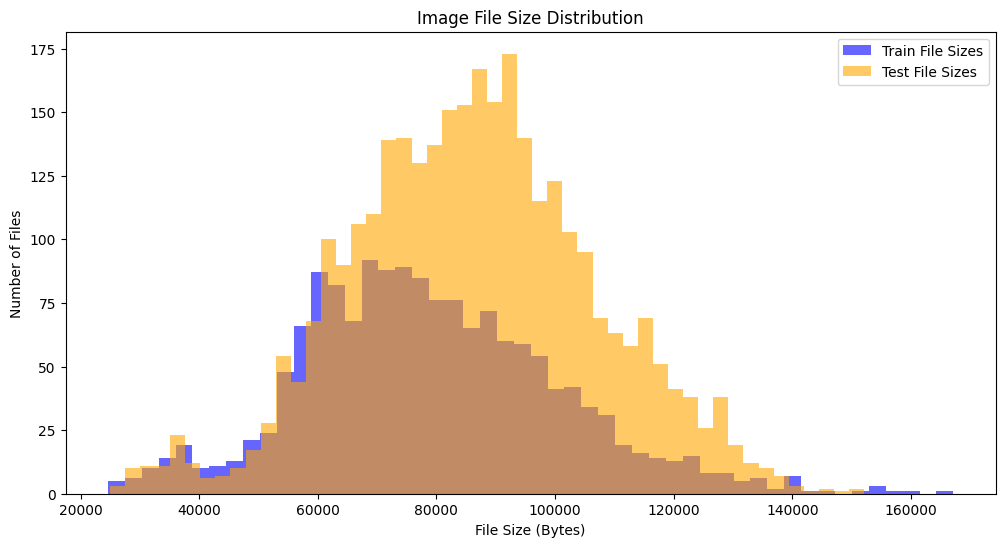

In [5]:
# 파일 크기 계산 함수
def calculate_file_sizes(image_folder):
    file_sizes = []
    for img_file in os.listdir(image_folder):
        if img_file.endswith(".jpg"):
            file_sizes.append(os.path.getsize(os.path.join(image_folder, img_file)))
    return file_sizes

# Train/Test 이미지 파일 크기 시각화
train_file_sizes = calculate_file_sizes(train_image_path)
test_file_sizes = calculate_file_sizes(test_image_path)

# 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_file_sizes, bins=50, color='blue', alpha=0.6, label="Train File Sizes")
plt.hist(test_file_sizes, bins=50, color='orange', alpha=0.6, label="Test File Sizes")
plt.title("Image File Size Distribution")
plt.xlabel("File Size (Bytes)")
plt.ylabel("Number of Files")
plt.legend()
plt.show()


### 클래스 불균형 시각화 (히스토그램/막대그래프)

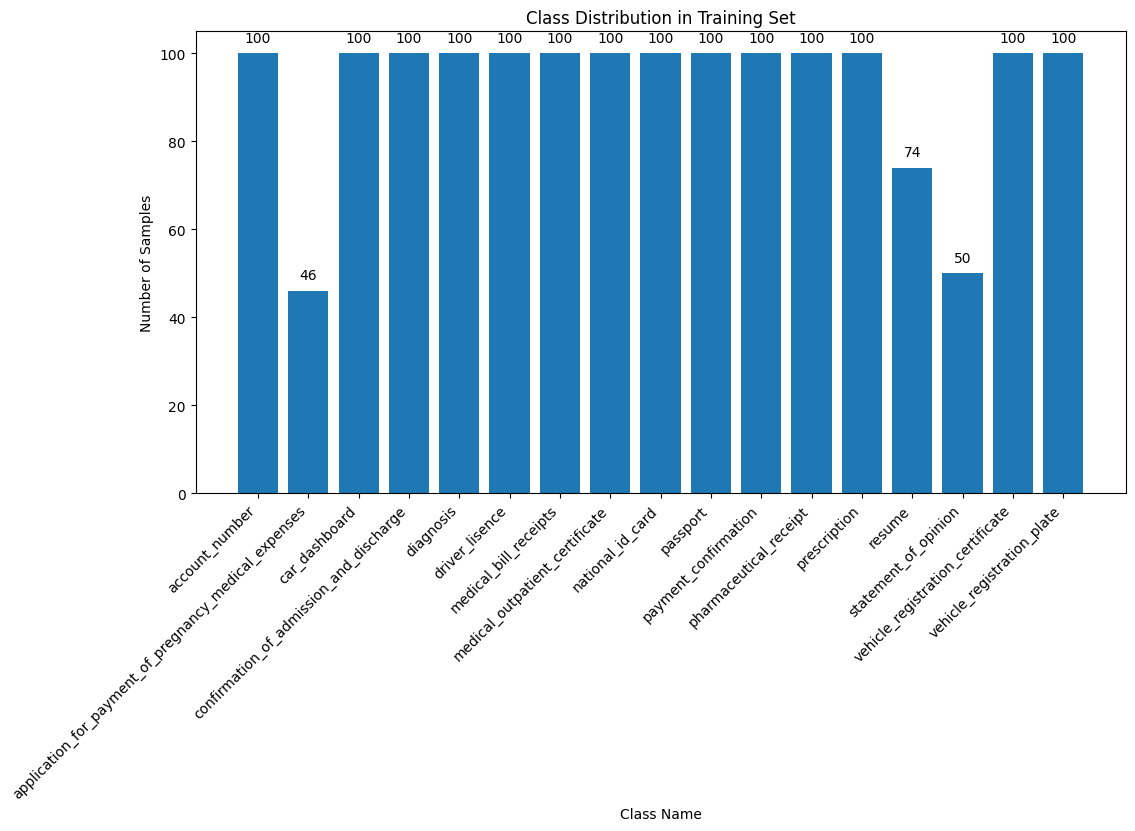

In [6]:
# 클래스별 데이터 개수 확인
class_counts = train_df['target'].value_counts().sort_index()
class_names = meta_df.set_index('target')['class_name']

# 클래스 분포 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names[class_counts.index], class_counts)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Name')
plt.ylabel('Number of Samples')
plt.show()


## 이미지 품질 검사

### 이미지 깨짐 확인

In [7]:
# 이미지 깨짐 확인 함수
def check_corrupted_images(image_folder):
    corrupted_files = []
    for img_file in os.listdir(image_folder):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(image_folder, img_file)
            try:
                img = Image.open(img_path)
                img.verify()  # 손상된 이미지 검사
            except (IOError, SyntaxError):
                corrupted_files.append(img_file)
    return corrupted_files

# 검사 실행
train_corrupted_images = check_corrupted_images(train_image_path)
test_corrupted_images = check_corrupted_images(test_image_path)

print(f"Train 데이터에서 손상된 이미지 수: {len(train_corrupted_images)}")
print(f"Test 데이터에서 손상된 이미지 수: {len(test_corrupted_images)}")


Train 데이터에서 손상된 이미지 수: 0
Test 데이터에서 손상된 이미지 수: 0


### RGB 채널 비율 확인

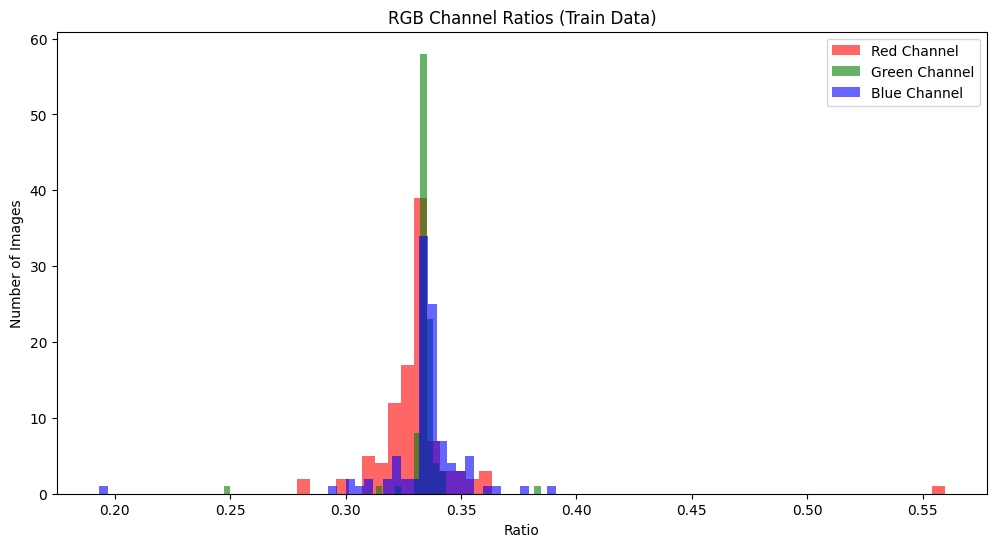

In [8]:
# 이미지 RGB 비율 계산 함수
def calculate_rgb_ratios(image_folder, sample_size=100):
    rgb_ratios = []
    sample_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][:sample_size]
    for img_file in sample_images:
        img_path = os.path.join(image_folder, img_file)
        img = Image.open(img_path).convert("RGB")
        rgb_mean = np.mean(np.array(img), axis=(0, 1))
        rgb_ratios.append(rgb_mean / np.sum(rgb_mean))
    return np.array(rgb_ratios)

# RGB 비율 계산
train_rgb_ratios = calculate_rgb_ratios(train_image_path)
test_rgb_ratios = calculate_rgb_ratios(test_image_path)

# 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_rgb_ratios[:, 0], bins=50, color='red', alpha=0.6, label='Red Channel')
plt.hist(train_rgb_ratios[:, 1], bins=50, color='green', alpha=0.6, label='Green Channel')
plt.hist(train_rgb_ratios[:, 2], bins=50, color='blue', alpha=0.6, label='Blue Channel')
plt.title("RGB Channel Ratios (Train Data)")
plt.xlabel("Ratio")
plt.ylabel("Number of Images")
plt.legend()
plt.show()


## 이미지 시각적 탐색

### 랜덤 샘플 이미지 시각화

Train 데이터 랜덤 샘플 이미지:


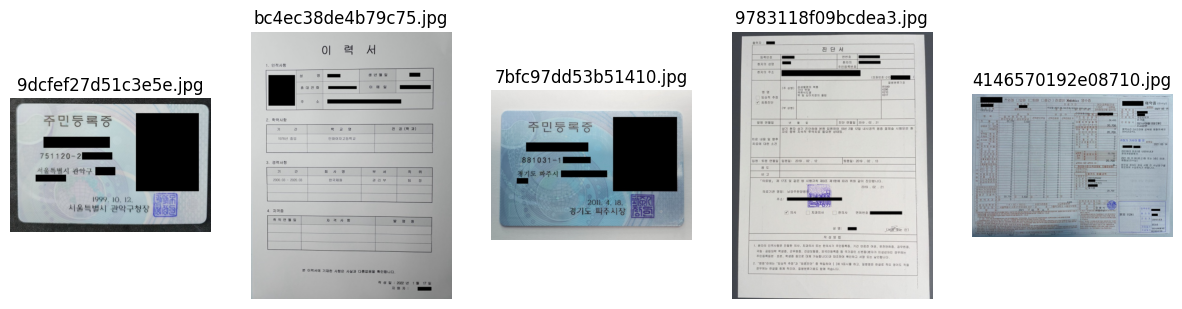

Test 데이터 랜덤 샘플 이미지:


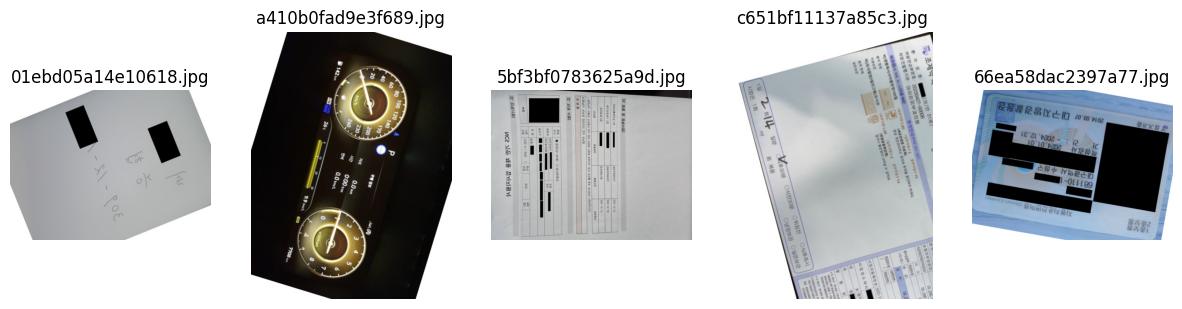

In [9]:
# 랜덤 샘플 이미지 시각화 함수
import random

def visualize_random_images(image_folder, sample_size=5):
    sample_images = random.sample(
        [img for img in os.listdir(image_folder) if img.endswith(".jpg")], sample_size)
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(image_folder, img_file))
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file)
    plt.show()

# Train 데이터 샘플 이미지 시각화
print("Train 데이터 랜덤 샘플 이미지:")
visualize_random_images(train_image_path)

# Test 데이터 샘플 이미지 시각화
print("Test 데이터 랜덤 샘플 이미지:")
visualize_random_images(test_image_path)


### 해상도가 너무 크거나 작은 이미지 시각화

In [10]:
# 특이 해상도 이미지 필터링 함수
def find_outlier_resolutions(image_folder, min_size=100, max_size=2000):
    outlier_images = []
    for img_file in os.listdir(image_folder):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(image_folder, img_file)
            img = Image.open(img_path)
            width, height = img.size
            if width < min_size or height < min_size or width > max_size or height > max_size:
                outlier_images.append((img_file, (width, height)))
    return outlier_images

# Train 데이터에서 해상도 이상치 탐색
train_outliers = find_outlier_resolutions(train_image_path)

# 시각화
plt.figure(figsize=(15, 5))
for i, (img_file, resolution) in enumerate(train_outliers[:5]):
    img = Image.open(os.path.join(train_image_path, img_file))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{img_file}\n{resolution}')
plt.show()


<Figure size 1500x500 with 0 Axes>

## 픽셀 기반 분석

### 픽셀 값 통계 확인 (평균, 표준 편차 등)

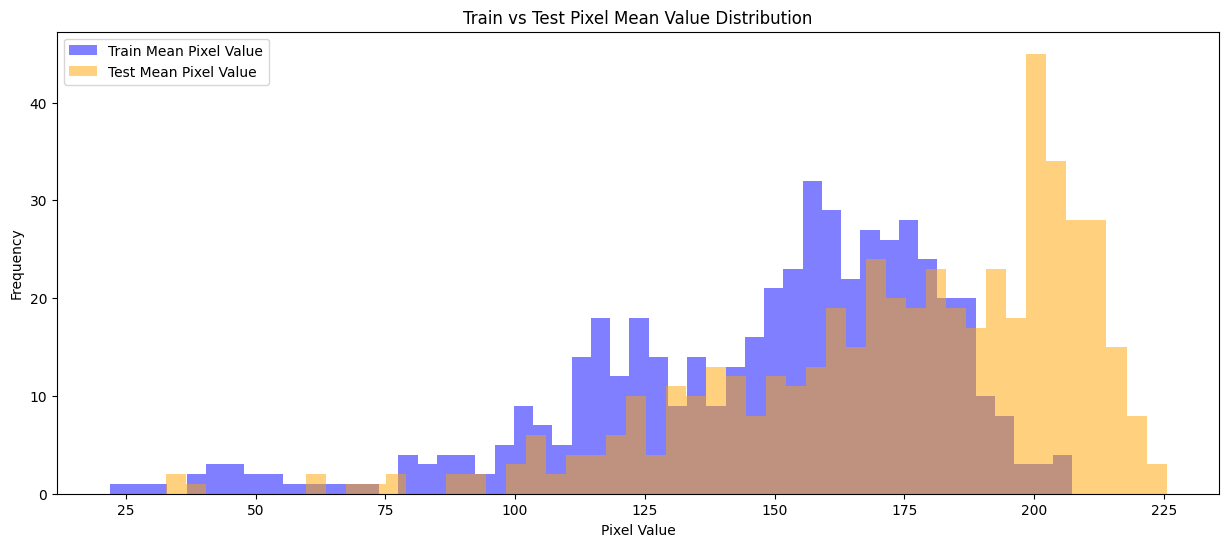

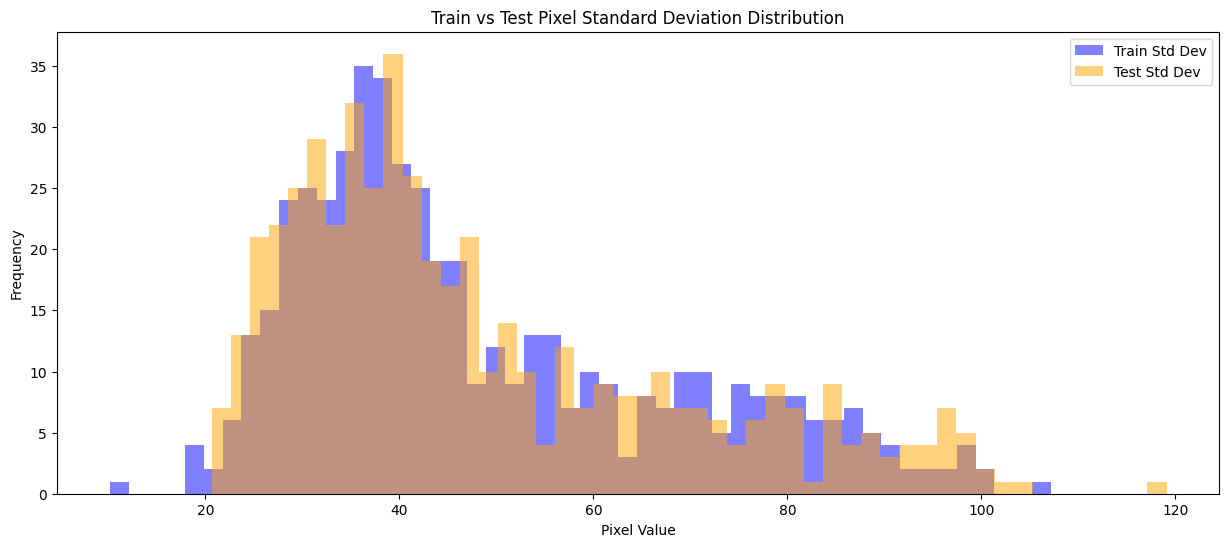

In [11]:
# 픽셀 값 통계 계산 함수
def calculate_pixel_statistics(image_folder, sample_size=100):
    pixel_stats = []
    sample_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][:sample_size]
    for img_file in sample_images:
        img = Image.open(os.path.join(image_folder, img_file)).convert("L")  # 흑백 변환
        pixel_values = np.array(img).flatten()
        mean_val = np.mean(pixel_values)
        std_val = np.std(pixel_values)
        min_val = np.min(pixel_values)
        max_val = np.max(pixel_values)
        pixel_stats.append([img_file, mean_val, std_val, min_val, max_val])
    stats_df = pd.DataFrame(pixel_stats, columns=['Image', 'Mean', 'Std', 'Min', 'Max'])
    return stats_df

# Train 및 Test 데이터 픽셀 값 통계 계산
train_pixel_stats = calculate_pixel_statistics(train_image_path, sample_size=500)
test_pixel_stats = calculate_pixel_statistics(test_image_path, sample_size=500)

# 히스토그램 시각화
plt.figure(figsize=(15, 6))
plt.hist(train_pixel_stats['Mean'], bins=50, color='blue', alpha=0.5, label='Train Mean Pixel Value')
plt.hist(test_pixel_stats['Mean'], bins=50, color='orange', alpha=0.5, label='Test Mean Pixel Value')
plt.title("Train vs Test Pixel Mean Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 표준편차 비교 히스토그램
plt.figure(figsize=(15, 6))
plt.hist(train_pixel_stats['Std'], bins=50, color='blue', alpha=0.5, label='Train Std Dev')
plt.hist(test_pixel_stats['Std'], bins=50, color='orange', alpha=0.5, label='Test Std Dev')
plt.title("Train vs Test Pixel Standard Deviation Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### 밝기 평균 비교

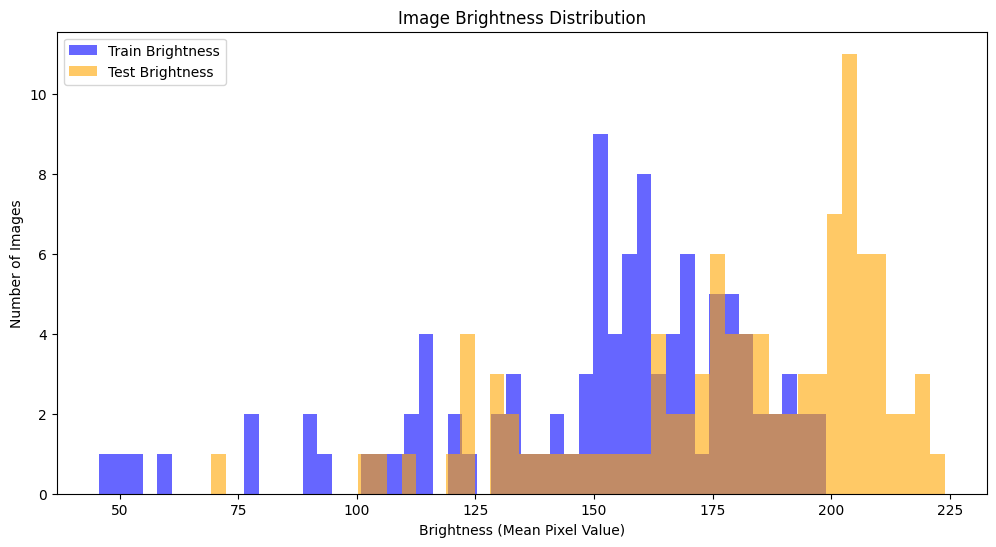

In [12]:
# 밝기 평균 계산 함수
def calculate_brightness(image_folder, sample_size=100):
    brightness_values = []
    sample_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][:sample_size]
    for img_file in sample_images:
        img = Image.open(os.path.join(image_folder, img_file)).convert("L")
        brightness_values.append(np.mean(np.array(img)))
    return brightness_values

# 밝기 평균 계산
train_brightness = calculate_brightness(train_image_path)
test_brightness = calculate_brightness(test_image_path)

# 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_brightness, bins=50, color='blue', alpha=0.6, label='Train Brightness')
plt.hist(test_brightness, bins=50, color='orange', alpha=0.6, label='Test Brightness')
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness (Mean Pixel Value)")
plt.ylabel("Number of Images")
plt.legend()
plt.show()


### 데이터셋 검증 및 품질 관리

### 중복 이미지 확인

In [13]:
import hashlib

# 중복 이미지 확인 함수
def find_duplicate_images(image_folder):
    hash_set = set()
    duplicates = []
    for img_file in os.listdir(image_folder):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(image_folder, img_file)
            with open(img_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash in hash_set:
                    duplicates.append(img_file)
                else:
                    hash_set.add(file_hash)
    return duplicates

# 중복 이미지 확인
train_duplicates = find_duplicate_images(train_image_path)
test_duplicates = find_duplicate_images(test_image_path)

print(f"Train 데이터에서 중복된 이미지 수: {len(train_duplicates)}")
print(f"Test 데이터에서 중복된 이미지 수: {len(test_duplicates)}")


Train 데이터에서 중복된 이미지 수: 0
Test 데이터에서 중복된 이미지 수: 0


## 데이터 준비를 위한 추가 작업

### 이미지 리사이징 시각화

Train 데이터 리사이징 샘플:


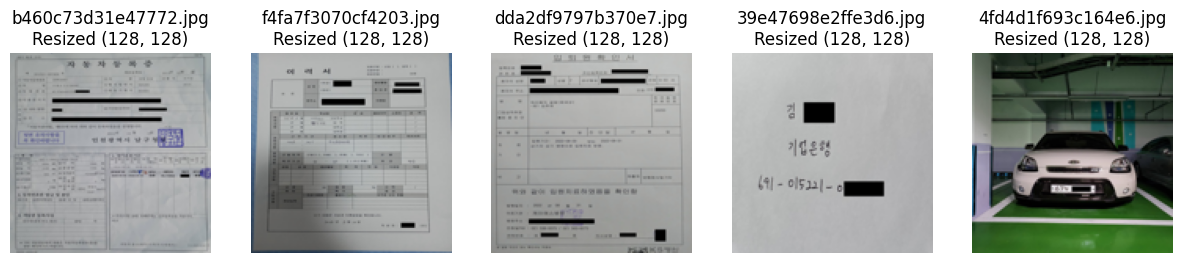

In [14]:
# 이미지 리사이징 함수
def resize_and_visualize(image_folder, sample_size=5, target_size=(128, 128)):
    sample_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][:sample_size]
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(image_folder, img_file)).resize(target_size)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{img_file}\nResized {target_size}")
    plt.show()

# Train 데이터 리사이징 시각화
print("Train 데이터 리사이징 샘플:")
resize_and_visualize(train_image_path, sample_size=5)


### 데이터 증강 샘플링 확인

Train 데이터 증강 샘플:


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


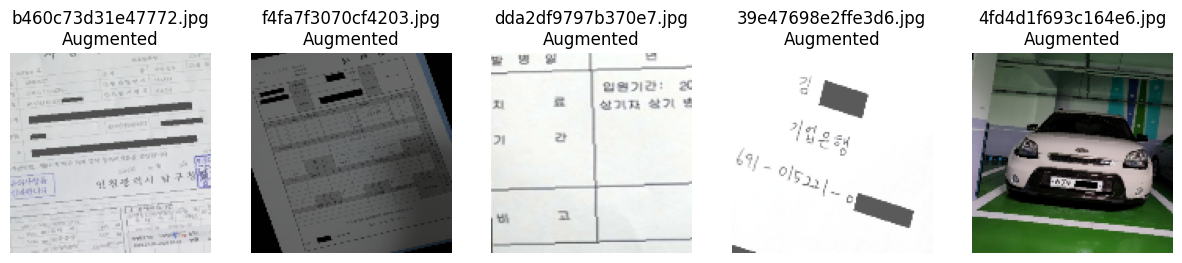

In [15]:
from torchvision import transforms

# 데이터 증강 설정
augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomResizedCrop(128)
])

# 데이터 증강 시각화
def visualize_augmentation(image_folder, sample_size=5):
    sample_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][:sample_size]
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(image_folder, img_file))
        augmented_img = augmentation(transforms.ToTensor()(img)).permute(1, 2, 0)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(augmented_img)
        plt.axis('off')
        plt.title(f"{img_file}\nAugmented")
    plt.show()

# Train 데이터 증강 확인
print("Train 데이터 증강 샘플:")
visualize_augmentation(train_image_path, sample_size=5)


### 클래스별 데이터 비율 유지 확인

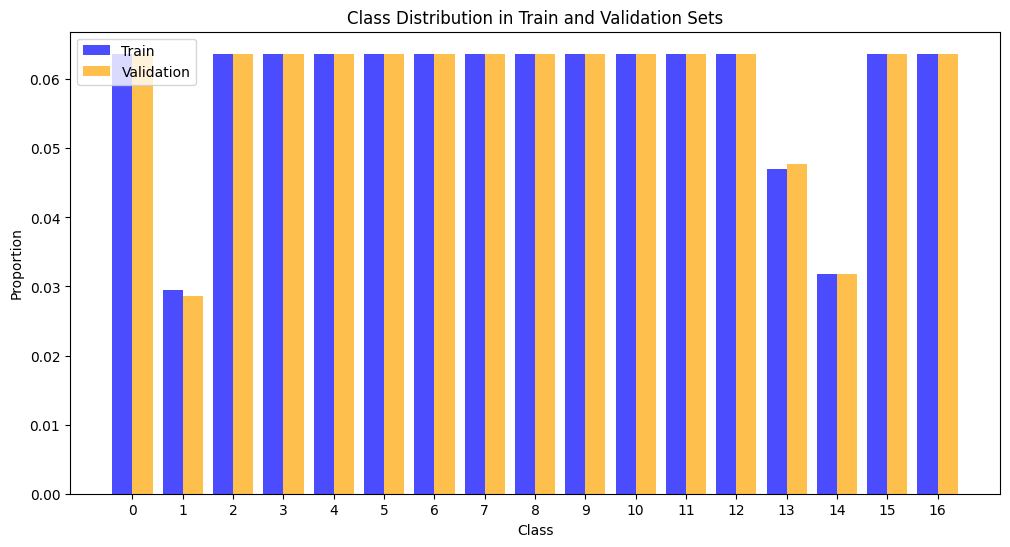

In [16]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 클래스별 비율 계산 함수
def check_class_distribution(df, class_col='target'):
    class_counts = df[class_col].value_counts(normalize=True).sort_index()
    return class_counts

# Train/Validation/Test 데이터 분할
train_df_split, val_df_split = train_test_split(
    train_df, test_size=0.2, stratify=train_df['target'], random_state=42
)

# 클래스 비율 계산
train_class_distribution = check_class_distribution(train_df_split)
val_class_distribution = check_class_distribution(val_df_split)

# 시각화: Train과 Validation 클래스 비율 비교
plt.figure(figsize=(12, 6))
width = 0.4  # 막대 폭 설정

# Train과 Validation의 클래스 비율을 나란히 표시
train_x = train_class_distribution.index - width / 2
val_x = val_class_distribution.index + width / 2

plt.bar(train_x, train_class_distribution.values, width=width, alpha=0.7, label="Train", color='blue')
plt.bar(val_x, val_class_distribution.values, width=width, alpha=0.7, label="Validation", color='orange')

# 그래프 제목 및 레이블 설정
plt.title("Class Distribution in Train and Validation Sets")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.xticks(train_class_distribution.index)  # X축 눈금 설정
plt.legend()
plt.show()


## 고급 분석

### 이미지 유사도 검사 (Feature Extraction)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


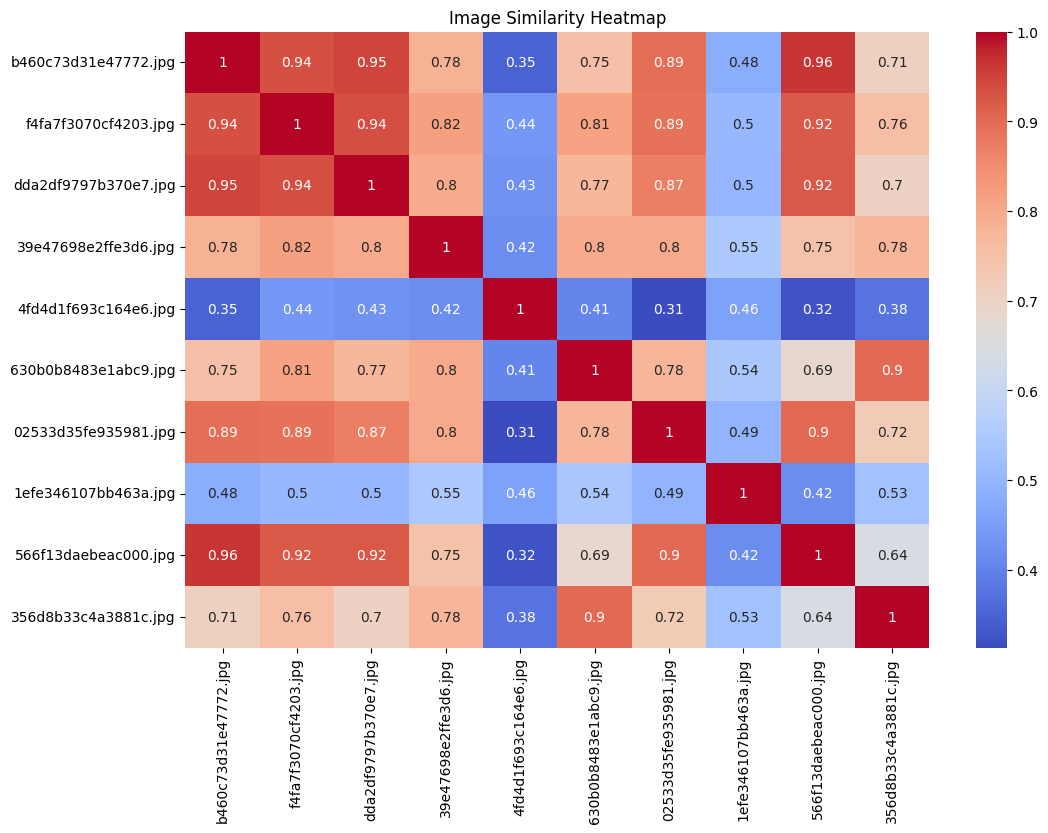

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import models
import torch

# 이미지 특징 추출 함수 (ResNet50 사용)
def extract_features(image_folder, sample_size=10, model=None):
    if model is None:
        model = models.resnet50(pretrained=True)
        model.eval()

    features = []
    sample_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][:sample_size]
    for img_file in sample_images:
        img = Image.open(os.path.join(image_folder, img_file)).resize((224, 224)).convert('RGB')
        img_tensor = transforms.ToTensor()(img).unsqueeze(0)
        with torch.no_grad():
            feature_vector = model(img_tensor).numpy().flatten()
            features.append((img_file, feature_vector))
    return features

# 특징 추출 실행
train_features = extract_features(train_image_path, sample_size=10)

# 유사도 계산
file_names, feature_vectors = zip(*train_features)
similarity_matrix = cosine_similarity(feature_vectors)

# 시각화
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=file_names, yticklabels=file_names, cmap="coolwarm", annot=True)
plt.title("Image Similarity Heatmap")
plt.show()


### 이미지 클러스터링 (KMeans)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_79391/3436770950.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cluster_df, x='Cluster', palette='coolwarm')


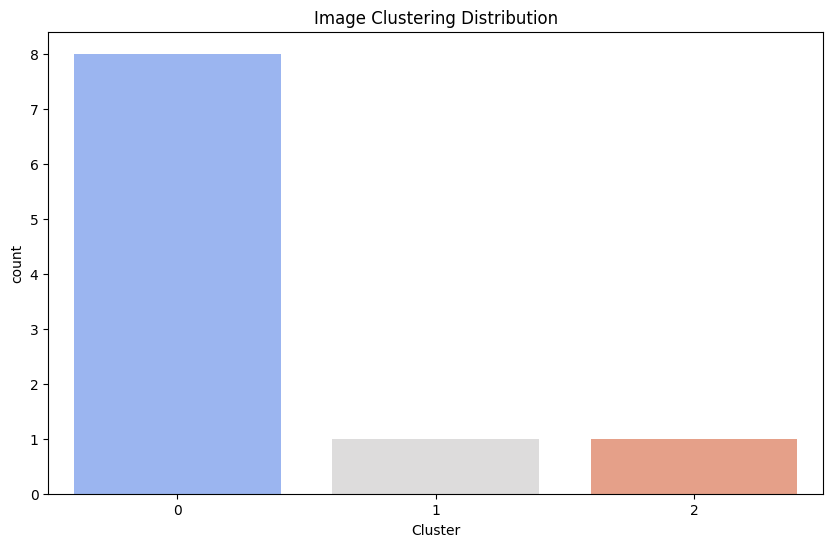

In [18]:
from sklearn.cluster import KMeans

# KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(feature_vectors)

# 시각화
cluster_df = pd.DataFrame({'File': file_names, 'Cluster': clusters})
plt.figure(figsize=(10, 6))
sns.countplot(data=cluster_df, x='Cluster', palette='coolwarm')
plt.title("Image Clustering Distribution")
plt.show()


### 모델 예측 결과 시각화

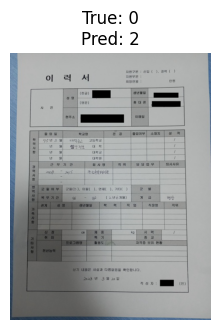

In [19]:
# 잘못 예측된 이미지 시각화 (예시)
def visualize_misclassified_images(predicted_labels, true_labels, image_folder, file_names):
    incorrect_indices = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred != true]
    plt.figure(figsize=(15, 5))
    for idx, i in enumerate(incorrect_indices[:5]):
        img = Image.open(os.path.join(image_folder, file_names[i]))
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.show()

# 예시 실행 (모델 훈련 이후 필요)
predicted_labels = [1, 2, 0, 2, 1]  # 예시
true_labels = [1, 0, 0, 2, 1]       # 예시

visualize_misclassified_images(predicted_labels, true_labels, train_image_path, file_names)
